# Decision Trees

In [47]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz 

from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz 

### CART Example using Sklearn: Use a new Dataset, complete preprocessing, use three data
### partitions: Training, Tuning and Testing, and build a model!

In [48]:
#Read in the data from the github repo, you should also have this saved locally...
winequality = pd.read_csv("https://raw.githubusercontent.com/UVADS/DS-3001/main/data/winequality-red-ddl.csv")

In [49]:
#Let's take a look...
print(winequality.info())
print(winequality.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1575 non-null   float64
 2   citric acid           1595 non-null   float64
 3   residual sugar        1586 non-null   float64
 4   chlorides             1587 non-null   float64
 5   free sulfur dioxide   1583 non-null   float64
 6   total sulfur dioxide  1574 non-null   float64
 7   density               1579 non-null   float64
 8   pH                    1597 non-null   float64
 9   sulphates             1591 non-null   float64
 10  alcohol               1589 non-null   float64
 11  quality               1581 non-null   float64
 12  text_rank             1581 non-null   object 
dtypes: float64(12), object(1)
memory usage: 162.5+ KB
None
   fixed acidity  volatile acidity  citric acid  residual sugar  chl

In [50]:
#This will be our target variable
print(winequality.text_rank.value_counts())

ave            678
average-ish    630
good           193
poor-ish        53
excellent       17
poor            10
Name: text_rank, dtype: int64


## Preprocessing

In [51]:
#drop qaulity column since it predicts text_rank perfectly
winequality= winequality.drop(columns='quality')

## Missing Data 

In [52]:
#Let's see if we have any NA's
print(winequality.isna().sum()) #show location of NA's by variable

fixed acidity            0
volatile acidity        24
citric acid              4
residual sugar          13
chlorides               12
free sulfur dioxide     16
total sulfur dioxide    25
density                 20
pH                       2
sulphates                8
alcohol                 10
text_rank               18
dtype: int64


In [53]:
#Let's just drop them
winequality= winequality.dropna()

In [54]:
print(winequality.info()) #Lost some rows, but should be fine with this size dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482 entries, 0 to 1580
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1482 non-null   float64
 1   volatile acidity      1482 non-null   float64
 2   citric acid           1482 non-null   float64
 3   residual sugar        1482 non-null   float64
 4   chlorides             1482 non-null   float64
 5   free sulfur dioxide   1482 non-null   float64
 6   total sulfur dioxide  1482 non-null   float64
 7   density               1482 non-null   float64
 8   pH                    1482 non-null   float64
 9   sulphates             1482 non-null   float64
 10  alcohol               1482 non-null   float64
 11  text_rank             1482 non-null   object 
dtypes: float64(11), object(1)
memory usage: 150.5+ KB
None


## Collapsing the target

In [55]:
#Let's collapse text_rank now into only two classes
winequality.text_rank.value_counts() #What should we combine?

ave            635
average-ish    583
good           186
poor-ish        51
excellent       17
poor            10
Name: text_rank, dtype: int64

In [56]:
#Condense everything into either average or excellent
winequality["text_rank"]= winequality["text_rank"].replace(['good','average-ish','poor-ish','poor'], ['excellent','ave','ave','ave'])
print(winequality["text_rank"].value_counts()) #Great!

ave          1279
excellent     203
Name: text_rank, dtype: int64


In [57]:
#check the prevalence
print(203/(1279+203))

0.1369770580296896


In [58]:
#Before we start move forward, we have one more preprocessing step
#We must encode text_rank to become a continuous variable as that is the only type sklearn deicsion trees can currently take
winequality[["text_rank"]] = OrdinalEncoder().fit_transform(winequality[["text_rank"]])
print(winequality["text_rank"].value_counts()) #nice

0.0    1279
1.0     203
Name: text_rank, dtype: int64


## Splitting the Data

In [59]:
#split independent and dependent variables 
X= winequality.drop(columns='text_rank')
y= winequality.text_rank

In [60]:
#There is not a easy way to create 3 partitions using the train_test_split
#so we are going to use it twice. Mostly because we want to stratify on the variable we are working to predict. What does that mean?  

#what should I stratify by??? Our Target!
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, stratify= y, random_state=21)
X_tune, X_test, y_tune, y_test = train_test_split(X_test,y_test,  train_size = 0.50,stratify= y_test, random_state=49)


## Let's Build the Model 

In [61]:
#Three steps in building a ML model
#Step 1: Cross validation process- the process by which the training data will be used to build the initial model must be set. As seen below:

kf = RepeatedStratifiedKFold(n_splits=10,n_repeats =5, random_state=42)
# number - number of folds
# repeats - number of times the CV is repeated, takes the average of these repeat rounds

# This essentially will split our training data into k groups. For each unique group it will hold out one as a test set
# and take the remaining groups as a training set. Then, it fits a model on the training set and evaluates it on the test set.
# Retains the evaluation score and discards the model, then summarizes the skill of the model using the sample of model evaluation scores we choose

In [62]:
#What score do we want our model to be built on? Let's use:
#AUC for the ROC curve - remember this is measures how well our model distiguishes between classes
#Recall - this is sensitivity of our model, also known as the true positive rate (predicted pos when actually pos)
#Balanced accuracy - this is the (sensitivity + specificity)/2, or we can just say it is the number of correctly predicted data points
print(metrics.SCORERS.keys()) #find them

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [63]:
#Define score, these are the keys we located above. This is what the models will be scored by
scoring = ['roc_auc','recall','balanced_accuracy']

In [64]:
#Step 2: Usually involves setting a hyper-parameter search. This is optional and the hyper-parameters vary by model. 
#define parameters, we can use any number of the ones below but let's start with only max depth
#this will help us find a good balance between under fitting and over fitting in our model

param={"max_depth" : [1,2,3,4,5,6,7,8,9,10,11],
        #"splitter":["best","random"],
        #"min_samples_split":[5,10,15,20,25],
        #"min_samples_leaf":[5,10,15,20,25],
        #"min_weight_fraction_leaf":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
        #"max_features":["auto","log2","sqrt",None],
        #"max_leaf_nodes":[10,20,30,40,50],
        #'min_impurity_decrease':[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01],
        #'ccp_alpha' :[.001, .01, .1]
           }

In [65]:
#Step 3: Train the Model

#Classifier model we will use
cl= DecisionTreeClassifier(random_state=1000)

#Set up search for best decisiontreeclassifier estimator across all of our folds based on roc_auc
search = GridSearchCV(cl, param, scoring=scoring, n_jobs=-1, cv=kf,refit='roc_auc')

#execute search on our training data, this may take a few seconds ...
model = search.fit(X_train, y_train)

## Let's see how we did

In [66]:
#Retrieve the best estimator out of all parameters passed, based on highest roc_auc
best = model.best_estimator_
print(best) #depth of 5, good

DecisionTreeClassifier(max_depth=5, random_state=1000)


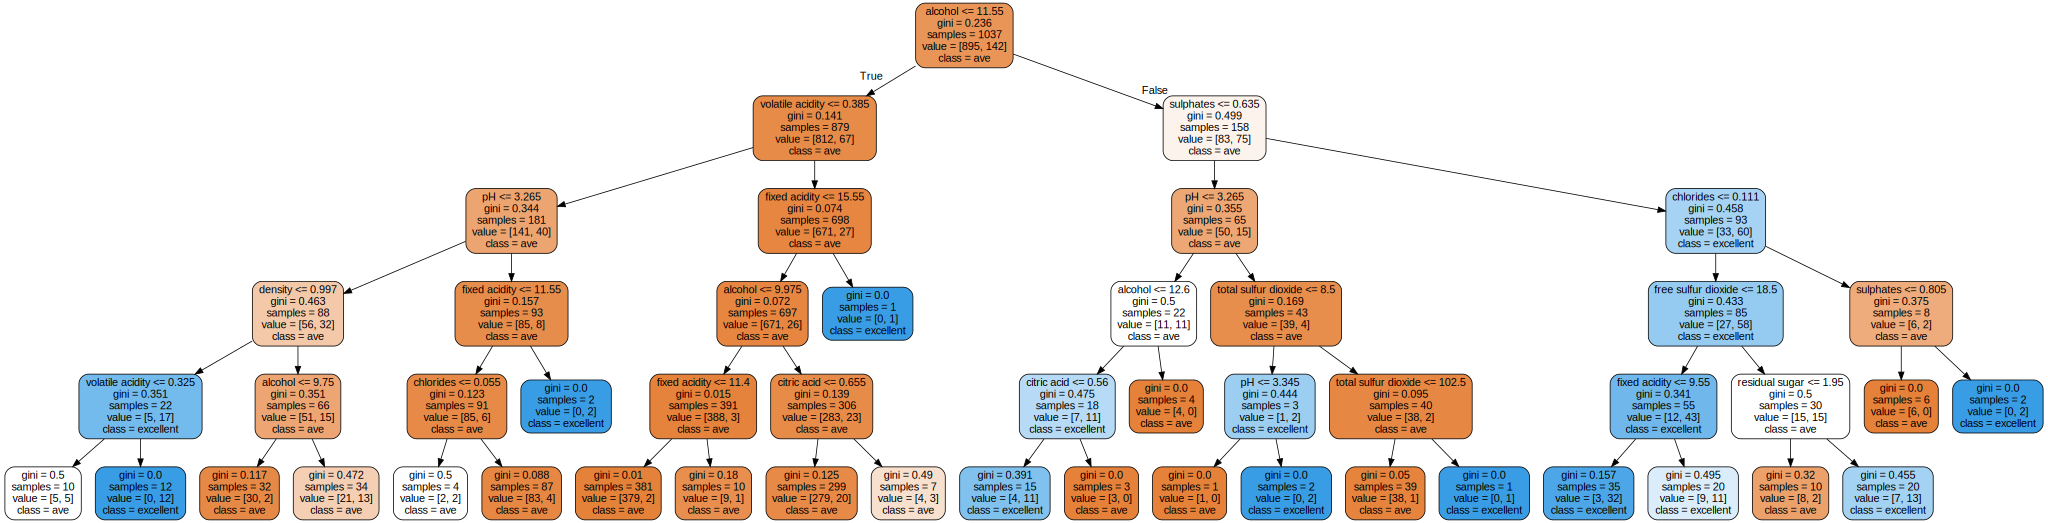

In [67]:
#Plotting the decision tree for the best estimator 
dot_data = export_graphviz(best, out_file =None,
               feature_names =X.columns, #feature names from dataset
               filled=True, 
                rounded=True, 
                class_names = ['ave','excellent']) #classification labels 
               
graph=graphviz.Source(dot_data)
graph

In [ ]:
#What about the specific scores (roc_auc, recall, balanced_accuracy)? Let's try and extract them to see what we are working with ...
print(model.cv_results_) #This is a dictionary and in order to extract info we need the keys

In [ ]:
#Which one of these do we need?
print(model.cv_results_.keys()) #get mean_test and std_test for all of our scores, and will need our param_max_depth as well 

In [24]:
#Let's extract these scores, using our function!

#Scores: 

auc = model.cv_results_['mean_test_roc_auc']
recall= model.cv_results_['mean_test_recall']
bal_acc= model.cv_results_['mean_test_balanced_accuracy']

SDauc = model.cv_results_['std_test_roc_auc']
SDrecall= model.cv_results_['std_test_recall']
SDbal_acc= model.cv_results_['std_test_balanced_accuracy']

#Parameter:
depth= np.unique(model.cv_results_['param_max_depth']).data

#Build DataFrame:
final_model = pd.DataFrame(list(zip(depth, auc, recall, bal_acc,SDauc,SDrecall,SDbal_acc)),
               columns =['depth','auc','recall','bal_acc','aucSD','recallSD','bal_accSD'])

#Let's take a look
final_model.style.hide(axis='index')


NameError: name 'model' is not defined

In [ ]:
#Warning!
#If we used mutiple params... you won't be able to get the scores as easily
#Say we wanted to get the scores based on max_depth still, but this time we used the parameter ccp_alpha as well
#Use the np.where function to search for the indices where the other parameter equals their best result, in this say it is .001
#This is an example code to find auc: #model.cv_results_['mean_test_roc_auc'][np.where((model.cv_results_['param_ccp_alpha'] == .001))]
#Essentially takes indeces and resulting scores where the best parameters were used 

In [ ]:
#Check the depth ...
print(plt.plot(final_model.depth,final_model.auc)) #5 does in fact have the highest (best) AUC!

# Variable Importance

In [ ]:
#Variable importance for the best estimator, how much weight does each feature have in determining the classification?
varimp=pd.DataFrame(best.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

In [ ]:
#Graph variable importance
plt.figure(figsize=(10,7))
print(varimp.importance.nlargest(7).plot(kind='barh')) #Alcohol has the largest impact by far!

## Let's use the model to predict and the evaluate the performance

In [ ]:
#Confusion Matrix time! Passing our tuning data into our best model, let's see how we do ...
print(ConfusionMatrixDisplay.from_estimator(best,X_tune,y_tune, display_labels = ['ave','excellent'], colorbar=False))

## Let's play with the threshold, what do we see 

In [ ]:
## Adjust threshold function
def adjust_thres(model,X,y_true, thres):
  #model= best estimator, X= feature vairables, y_true= target variables, thres = threshold
  y_pred = (model.predict_proba(X)[:,1] >= thres).astype(np.int32) #essentially changes the prediction cut off to our desired threshold
  return metrics.ConfusionMatrixDisplay.from_predictions(y_true,y_pred, display_labels = ['ave','excellent'], colorbar=False)

In [ ]:
#Where should we change the threshold to see a difference...
print(pd.DataFrame(model.predict_proba(X_tune)[:,1]).plot.density())

In [ ]:
#Let's try .1 as our new threshold ...
print(adjust_thres(best,X_tune, y_tune,.1))

## Accuracy Score

In [45]:
print(best.score(X_test,y_test)) #Pretty precise, nice!

NameError: name 'best' is not defined

In [ ]:
print(best.score(X_tune,y_tune)) #same with tuning set

## Feature Engineering: 

In [18]:
#What feature should we look at?
print(winequality.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1482.000000       1482.000000  1482.000000     1482.000000   
mean        8.320243          0.528870     0.269744        2.548853   
std         1.718001          0.180651     0.194912        1.431911   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1482.000000          1482.000000           1482.000000  1482.000000   
mean      0.087808            16.018893             46.965587     0.996764   
std       0.048015            10.419929             33.141959     0.001868   
min       0.012000             1.000000         

In [ ]:
# How about total sulfur dioxide ...
print(plt.hist(winequality['total sulfur dioxide'], width=15, bins = 15))

In [ ]:
#Get the five number summary, and some...
print(winequality['total sulfur dioxide'].describe())

In [ ]:
#make a new dataframe so we can preserve our working environment
winequality1 = winequality.copy(deep=True)

In [ ]:
#lump total sulfure dioxide to below and above its median (38)
winequality1['total sulfur dioxide']=pd.cut(winequality1['total sulfur dioxide'],(0,37,300), labels = ("low","high"))

In [ ]:
#transform it to a numeric variable so we can use it in sklearn decision tree
winequality1[["total sulfur dioxide"]] = OrdinalEncoder().fit_transform(winequality1[["total sulfur dioxide"]])

In [ ]:
#Separate features and target 
X1=winequality1.drop(columns='text_rank')
y1=winequality1.text_rank

In [ ]:
#Data splitting
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, train_size=0.70, stratify= y1, random_state=21)
X_tune1, X_test1, y_tune1, y_test1 = train_test_split(X_test1,y_test1,  train_size = 0.50,stratify= y_test1, random_state=49)

In [ ]:
#define search, model, paramameters and scoring will be the same...
search_eng = GridSearchCV(cl, param, scoring=scoring, n_jobs=-1, cv=kf,refit='roc_auc')

#execute search
model_eng = search_eng.fit(X_train1, y_train1)

In [ ]:
#Take a look at our best estimator for depth this time
best_eng = model_eng.best_estimator_ 
print(best_eng) #4, a different depth!

In [ ]:
#Check out the mean and standard deviation test scores again ...
auc = model_eng.cv_results_['mean_test_roc_auc']
recall= model_eng.cv_results_['mean_test_recall']
bal_acc= model_eng.cv_results_['mean_test_balanced_accuracy']

SDauc = model_eng.cv_results_['std_test_roc_auc']
SDrecall= model_eng.cv_results_['std_test_recall']
SDbal_acc= model_eng.cv_results_['std_test_balanced_accuracy']

#Parameter:
depth= np.unique(model_eng.cv_results_['param_max_depth']).data

#Build DataFrame:
final_model = pd.DataFrame(list(zip(depth, auc, recall, bal_acc,SDauc,SDrecall,SDbal_acc)),
               columns =['depth','auc','recall','bal_acc','aucSD','recallSD','bal_accSD'])

#Let's take a look
final_model.style.hide(axis='index')

# Compare the confusion matrices from the two models

In [ ]:
#First model
print(ConfusionMatrixDisplay.from_estimator(best,X_tune,y_tune,colorbar=False))

In [ ]:
#New engineered model
print(ConfusionMatrixDisplay.from_estimator(best_eng,X_tune1,y_tune1,colorbar=False)) #Better tpr and tnr!

## We can also review the variable importance

In [ ]:
#First model
print(pd.DataFrame(best.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))


In [ ]:
#Engineered model
print(pd.DataFrame(best_eng.feature_importances_,index = X1.columns,columns=['importance']).sort_values('importance', ascending=False))
#Smaller model so less variables are considered in the decision making for better or worse...

## Predict with test, how did we do? 

In [ ]:
#Original model
print(ConfusionMatrixDisplay.from_estimator(best,X_test,y_test,colorbar=False))

In [ ]:
#New engineered model
print(ConfusionMatrixDisplay.from_estimator(best_eng,X_test1,y_test1,colorbar=False)) #Ultimately, very similar results

## How about accuracy score?

In [ ]:
#Original model
print(best.score(X_test,y_test)) #accuracy 

In [ ]:
#Engineered model
print(best_eng.score(X_test1,y_test1)) #Basically the same

## Another example with a binary dataset this time!

In [27]:
#Load in new dataset
pregnancy = pd.read_csv("https://raw.githubusercontent.com/UVADS/DS-3001/main/data/pregnancy.csv")

In [28]:
#Let's get familiar with the data
print(pregnancy.info())
print(pregnancy.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Pregnancy Test          2000 non-null   int64
 1   Birth Control           2000 non-null   int64
 2   Feminine Hygiene        2000 non-null   int64
 3   Folic Acid              2000 non-null   int64
 4   Prenatal Vitamins       2000 non-null   int64
 5   Prenatal Yoga           2000 non-null   int64
 6   Body Pillow             2000 non-null   int64
 7   Ginger Ale              2000 non-null   int64
 8   Sea Bands               2000 non-null   int64
 9   Stopped buying ciggies  2000 non-null   int64
 10  Cigarettes              2000 non-null   int64
 11  Smoking Cessation       2000 non-null   int64
 12  Stopped buying wine     2000 non-null   int64
 13  Wine                    2000 non-null   int64
 14  Maternity Clothes       2000 non-null   int64
 15  PREGNANT             

In [29]:
#We want to build a classifier that can predict whether a shopper is pregnant
#based on the items they buy so we can direct-market to that customer if possible. 

print(pregnancy.PREGNANT.sum())
print(len(pregnancy.PREGNANT))

print((1- pregnancy.PREGNANT.sum()/len(pregnancy.PREGNANT)))
#What does .72 represent in this context? Prevalence of not being pregnant

560
2000
0.72


# reformat for exploration purposes

In [30]:
#Creating a vertical dataframe for the pregnant variable, just stacking the variables on top of each other. 
#First get the column names of features then use pd.melt based on the Pregnancy variable
feature_cols = pregnancy.drop(columns='PREGNANT').columns
pregnancy_long = df = pd.melt(pregnancy, id_vars='PREGNANT', value_vars=feature_cols,
             var_name='variable', value_name='value')


print(pregnancy_long.head())

   PREGNANT        variable  value
0         1  Pregnancy Test      1
1         1  Pregnancy Test      1
2         1  Pregnancy Test      1
3         1  Pregnancy Test      0
4         1  Pregnancy Test      0


# See what the base rate likihood of pregnancy looks like for each variable

In [31]:
# Calculate the probability of being pregnant by predictor variable.
# First let's create a new list to store our probability data
data=[]
#loop through features and retrieve probability of pregnancy for whether it is bought or not bought
#Since the data is binary you can take the average to get the probability.
for col in feature_cols:
    x = pregnancy.groupby([col])['PREGNANT'].mean()
    data.extend([[col,0,x[0]],[col,1,x[1]]])
base_rate = pd.DataFrame(data, columns = ['Var', 'Value','prob_pregnant'])
base_rate['prob_not_pregnant']= 1-base_rate.prob_pregnant
print(base_rate)

                       Var  Value  prob_pregnant  prob_not_pregnant
0           Pregnancy Test      0       0.254441           0.745559
1           Pregnancy Test      1       0.848837           0.151163
2            Birth Control      0       0.327859           0.672141
3            Birth Control      1       0.058989           0.941011
4         Feminine Hygiene      0       0.321212           0.678788
5         Feminine Hygiene      1       0.085714           0.914286
6               Folic Acid      0       0.234792           0.765208
7               Folic Acid      1       0.952381           0.047619
8        Prenatal Vitamins      0       0.236741           0.763259
9        Prenatal Vitamins      1       0.742690           0.257310
10           Prenatal Yoga      0       0.273647           0.726353
11           Prenatal Yoga      1       0.826087           0.173913
12             Body Pillow      0       0.276596           0.723404
13             Body Pillow      1       0.538462

# Build  the model 

In [32]:
#Split between features and target and do a three way split
X_preg=pregnancy.drop(columns='PREGNANT')
y_preg=pregnancy.PREGNANT
X_train_preg, X_test_preg, y_train_preg, y_test_preg = train_test_split(X_preg, y_preg, train_size=0.70, stratify= y_preg, random_state=21)
X_tune_preg, X_test_preg, y_tune_preg, y_test_preg = train_test_split(X_test_preg,y_test_preg,  train_size = 0.50,stratify= y_test_preg, random_state=49)

In [33]:
#This time we are going to use a different technique to complete our hyper-parameter search

#define our model, still using the same classifier as before
cl2=DecisionTreeClassifier(random_state=1000)

#prune our model using minimal cost-complexity pruning, this is an algorithm used to prune a tree to avoid over-fitting
path = cl2.cost_complexity_pruning_path(X_train_preg, y_train_preg)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

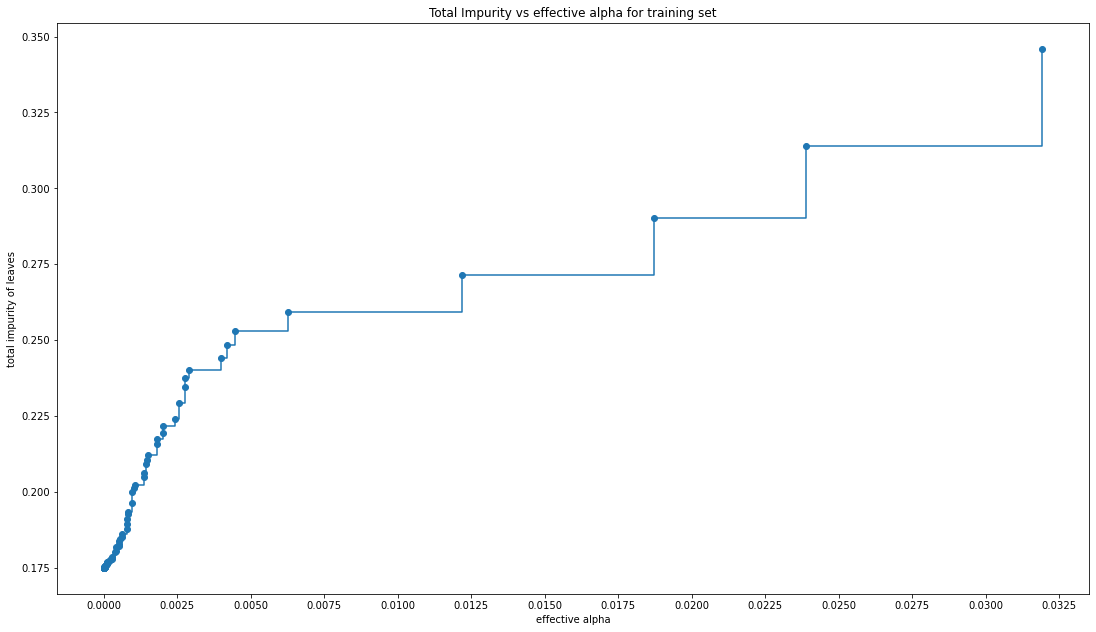

In [34]:
#Let's do some exploration into what cost complexity alpha gives the best results without overfitting or underfitting ...
fig, ax = plt.subplots()
#In the following plot, the maximum effective alpha value is removed, because it is the trivial tree with only one node
fig.set_size_inches(18.5, 10.5, forward=True)
plt.xticks(ticks=np.arange(0.00,0.06,.0025))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
#As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [35]:
#run through all of our alphas and create fitted decision tree classifiers for them so we can explore even further
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train_preg, y_train_preg)
    clfs.append(clf)


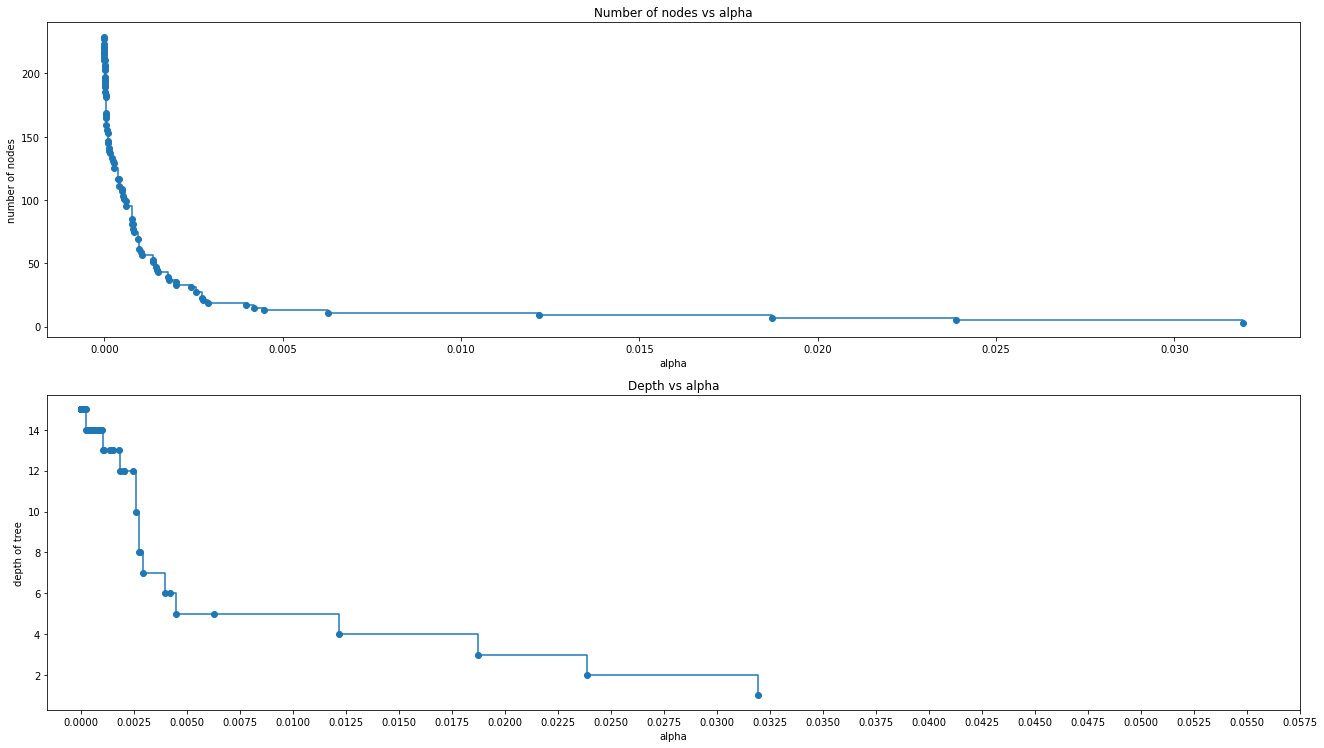

In [36]:
#we remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. 
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# Here we show that the number of nodes and tree depth decreases as alpha increases, makes sense since the tree is getting smaller
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.set_size_inches(18.5, 10.5, forward=True)
plt.xticks(ticks=np.arange(0.00,0.06,.0025))
fig.tight_layout()

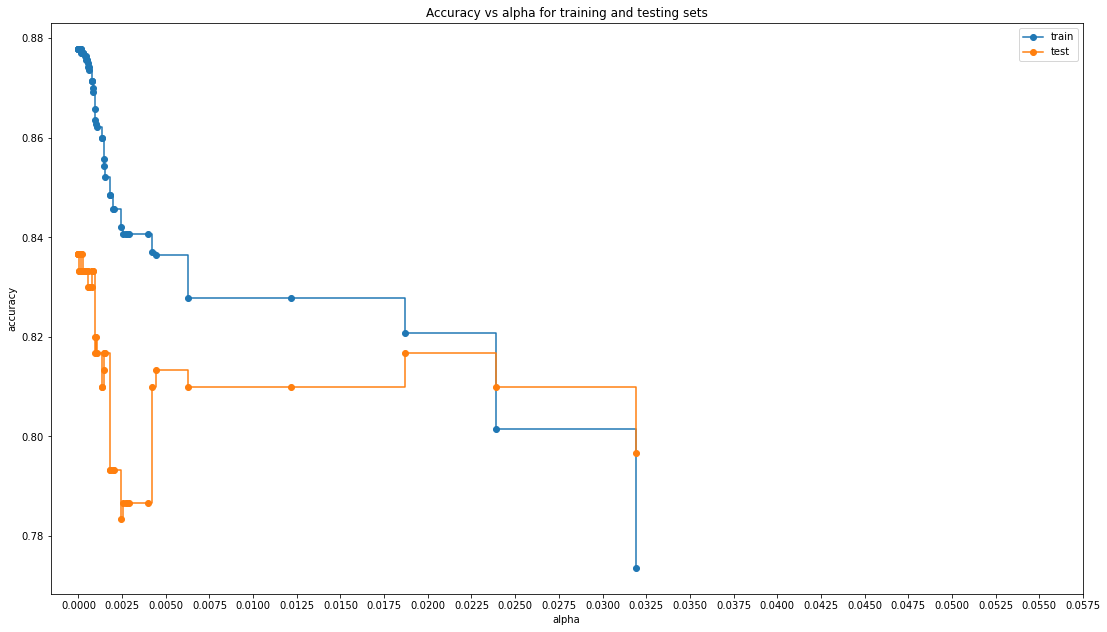

In [37]:
#When ccp_alpha is set to zero and keeping the other default parameters of DecisionTreeClassifier, 
#the tree overfits, leading to a 100% training accuracy and less testing accuracy. 
#As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. 
#Let's try and find the alpha where we get the highest accuracy for both training and testing data simultaneously 
train_scores = [clf.score(X_train_preg, y_train_preg) for clf in clfs]
test_scores = [clf.score(X_tune_preg, y_tune_preg) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.xticks(ticks=np.arange(0.00,0.06,.0025))
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()
#In this example, setting ccp_alpha=0.001 maximizes the testing accuracy.

In [38]:
#Let's take a look to get an exact value
tree=DecisionTreeClassifier(ccp_alpha= 0.001)
tree.fit(X_train_preg,y_train_preg)

0.8433333333333334

# Variable Importance

In [39]:
#Shows the reduction in error provided by including a given variable 
print(pd.DataFrame(tree.feature_importances_,index = X_preg.columns,columns=['importance']).sort_values('importance', ascending=False))

                        importance
Folic Acid                0.282159
Prenatal Vitamins         0.157229
Pregnancy Test            0.117627
Maternity Clothes         0.097533
Stopped buying wine       0.073541
Feminine Hygiene          0.064128
Birth Control             0.063039
Smoking Cessation         0.030172
Ginger Ale                0.029064
Wine                      0.024732
Cigarettes                0.023650
Stopped buying ciggies    0.018642
Sea Bands                 0.013422
Body Pillow               0.005061
Prenatal Yoga             0.000000


# Test the accuracy 

In [40]:
tree.score(X_test_preg,y_test_preg) #84% accurate, nice!

0.8433333333333334

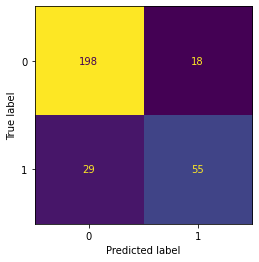

In [41]:
#Confusion matrix
ConfusionMatrixDisplay.from_estimator(tree,X_test_preg,y_test_preg, colorbar = False)

## Hit Rate or True Classification Rate, Detection Rate and ROC

In [42]:
# The error rate is defined as a classification of "Pregnant" when 
# this is not the case, and vice versa. It's the sum of all the
# values where a column contains the opposite value of the row.
pred_preg = tree.predict(X_test_preg)
tn, fp, fn, tp = metrics.confusion_matrix(y_test_preg,pred_preg).ravel()
# The error rate divides this figure by the total number of data points
# for which the forecast is created.
print("Hit Rate/True Error Rate = "+ str((fp+fn)/len(y_test_preg)*100))

Hit Rate/True Error Rate = 15.666666666666668


In [43]:
#Detection Rate is the rate at which the algo detects the positive class in proportion to the entire classification A/(A+B+C+D) where A is poss poss
print("Detection Rate = " +str((tp)/len(y_test_preg)*100)) #want this to be higher but there is only so high it can go...

Detection Rate = 18.333333333333332


Text(0.5, 0, 'False Positive Rate')

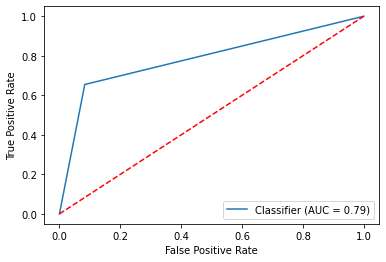

In [44]:
#Building the evaluation ROC and AUC using the predicted and original target variables 
metrics.RocCurveDisplay.from_predictions(y_test_preg,pred_preg)
#Set labels and midline...
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
#We can adjust using a if else statement and the predicted prob, now we have to be 75% sure to classify as pregnant
pred_adjusted = (tree.predict_proba(X_test_preg)[:,1] >= .75).astype(np.int32)
metrics.RocCurveDisplay.from_predictions(y_test_preg,pred_adjusted)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# We can also prune the tree to make it less complex 

In [ ]:
#Set parameters for our model, this time let's use the complexity parameter or the value of the splitting criterion 
param2={"max_depth" : [1,2,3,4,5,6,7],
        #"splitter":["best","random"],
        #'criterion': ['gini','entropy'],
        #"min_samples_split":[5,10,15,20,25],
        #"min_samples_leaf":[2,4,6,8,10],
        #"min_weight_fraction_leaf":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
        #"max_features":["auto","log2","sqrt",None],
        #"max_leaf_nodes":[10,20,30,40,50],
        #'min_impurity_decrease':[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01],
        'ccp_alpha' : [.001]
           }
# set our model
cl2=DecisionTreeClassifier(random_state=1000)
# set scoring
scoring2= ['roc_auc','recall','balanced_accuracy']
# define search
search_preg = GridSearchCV(cl2, param2, scoring=scoring2, n_jobs=-1, cv=kf,refit='roc_auc') 
#execute search
model_preg = search_preg.fit(X_train_preg, y_train_preg)

#Let's get our results!
best_preg= model_preg.best_estimator_
print(best_preg) #Now only has a max depth of 7

In [ ]:
print(tree.tree_.max_depth) #A lot better than 14!

In [ ]:
#let's take a look
dot_data = export_graphviz(best_preg, out_file =None,
               feature_names =X_preg.columns, #column names of our features
               filled=True, 
                rounded=True,
                class_names=['no','yes']) #classification labels
               
graph_preg=graphviz.Source(dot_data)
graph_preg

In [46]:
best_preg.score(X_test_preg,y_test_preg) #Same accuracy as well!

NameError: name 'best_preg' is not defined